# Exercise 4.4

## Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools

## Data

In [2]:
dolphin_conn = pd.read_csv('data/dolphins.txt', sep=" ", header=None, skiprows=1)
dolphin_info = pd.read_csv('data/dolphininfo.txt', sep=" ", header=None)
display(dolphin_conn)
display(dolphin_info)

,0,1
0,11,1
1,15,1
2,16,1
3,41,1
4,43,1
...,...,...
154,58,49
155,52,51
156,56,52
157,62,54


,0,1
0,Beak,M
1,Beescratch,M
2,Bumper,M
3,CCL,F
4,Cross,M
...,...,...
57,Web,M
58,Whitetip,F
59,Zap,U
60,Zig,M


## Networkx graph

In [3]:
dolphin_list = [(index+1, {'name': row[0], 'sex': row[1]}) for index, row in dolphin_info.iterrows()]
edge_list = [(row[0], row[1]) for _, row in dolphin_conn.iterrows()]

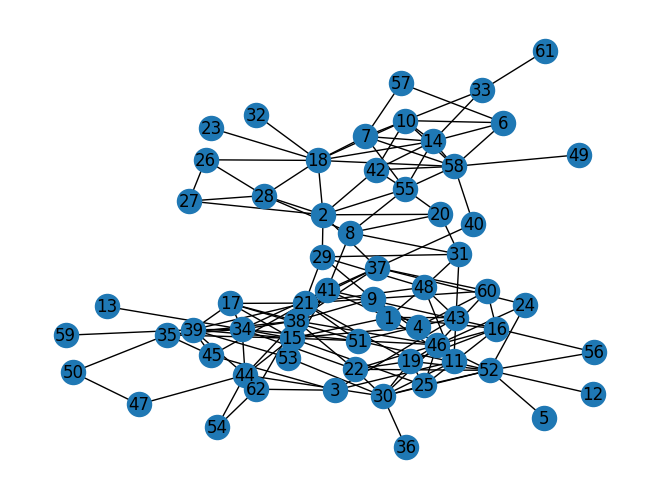

In [4]:
G = nx.Graph()
G.add_nodes_from(dolphin_list)
G.add_edges_from(edge_list)
nx.draw_kamada_kawai(G, with_labels=True)

## Algorithm

In [ ]:
def dfs(dolphins, alpha, size, improved, maximal):
  # Size parameter is such that len(smallest_clique)>size
  alpha_cliques = []
  count = 0 # Number of candidate sets traversed
  visited = set()

  for dolphin in list(dolphins):
    count_, _= dfs_rec(dolphins, frozenset([dolphin]), visited, alpha_cliques, alpha, size, improved, None)
    count += count_

  if maximal:
    # Inspiration from https://stackoverflow.com/questions/24075347/how-find-a-maximal-set-or-a-superset-from-a-list-of-sets-maximal-set-is-the-set
    lengths = set([len(i) for i in alpha_cliques])
    grouped = {l: [set(s) for s in alpha_cliques if l == len(s)] for l in lengths}
    max_cliques = []
    for l in lengths:
      max_cliques.extend([ list(s) for s in grouped[l] if not any([ other_s.intersection(s)==s for other_l in lengths if other_l !=l for other_s in grouped[other_l] ])])
    alpha_cliques = max_cliques

  return alpha_cliques, count


def dfs_rec(dolphins, dolphin_set, visited, alpha_cliques, alpha, size, improved, prunedeg_prev):
  count = 1 # Update number of candidate sets traversed
  visited.add(dolphin_set)
  stop = False
  S = dolphins.subgraph(dolphin_set)
  # Set pruning degree to None for improved algorithm
  prunedeg = None

  if len(dolphin_set) > 1: # Only calculate formulas for sets bigger than 1

    # Calculate f(S)
    min_deg = 100
    for d in dolphin_set:
      curr_deg = S.degree(d)
      if curr_deg < min_deg:
        min_deg = curr_deg

    f_S = min_deg/(len(dolphin_set)-1)

    # Check if S is an alpha-clique and add to result
    if f_S >= alpha and len(dolphin_set) > size and dolphin_set not in alpha_cliques:
      alpha_cliques.append(dolphin_set)

    # Prune based on Theorem
    for d in dolphin_set:
      thresh = 1 - (dolphins.degree(d)*(1-alpha))/((len(dolphin_set)-1)*alpha)
      if f_S < thresh:
        # If using improved algorithm, store degree of the pruned node
        if improved:
          prunedeg = dolphins.degree(d)
        stop = True
        break

  # If pruning condition is false move onto neighbours of current clique
  if not stop:
    # Iterate through all neighbours of S
    for neighbour in set(neighbor for d in dolphin_set for neighbor in dolphins.neighbors(d)):
      new_dolphin_set = frozenset([*dolphin_set, neighbour]) # Set with new dolphin
      # Check that new set is not already visited
      # and if using improved algorithm, check that the degree of the new dolphin is larger than 
      # that of the neighbour of S which satisfies the Theorem with smallest degree
      if (new_dolphin_set not in visited) and (not improved or ((prunedeg_prev is None) or (dolphins.degree(neighbour) >= prunedeg_prev))):
        count_, prunedeg_ = dfs_rec(dolphins, new_dolphin_set, visited, alpha_cliques, alpha, size, improved, prunedeg)
        # If using improved algorithm, update pruning degree
        if improved and (prunedeg is None or (prunedeg_ is not None and prunedeg_ < prunedeg)):
          prunedeg = prunedeg_
        count += count_

  # Return visit count and new pruning degree
  return count, prunedeg


## Toyset testing

### Download data

In [6]:
toyset = pd.read_csv('data/toyset.txt', sep=" ", header=None, skiprows=1)
toy_edge_list = [(row[0], row[1]) for _, row in toyset.iterrows()]
display(toyset)

,0,1
0,1,2
1,1,4
2,2,3
3,2,4
4,3,4
5,3,5


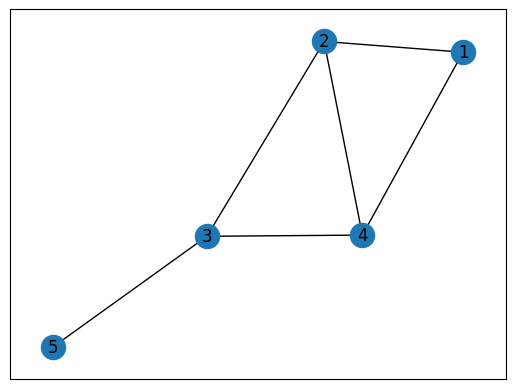

In [7]:
G_test = nx.Graph()
G_test.add_edges_from(toy_edge_list)
nx.draw_networkx(G_test, with_labels=True)

In [8]:
toy_res = dfs(G_test, 0.6, 2, True, False)
print(f"Number of toy example alpha-cliques: {len(toy_res[0])}")
print("The cliques:")
for i in toy_res[0]:
  print(i)

Number of toy example alpha-cliques: 3
The cliques:
frozenset({1, 2, 3, 4})
frozenset({1, 2, 4})
frozenset({2, 3, 4})


Result matches toysetresults.txt.

## Improved algorithm comparison

In [9]:
min_clique_size = 2
print(f"Cliques of size at least {min_clique_size}")
for i in [0.8, 0.7, 0.6, 0.5]:
  print(f"\nAlpha={i}")
  res_basic = dfs(G, i, min_clique_size-1, False, False)
  res_improved = dfs(G, i, min_clique_size-1, True, False)
  difference1 = [item for item in res_basic[0] if item not in res_improved[0]]
  difference2 = [item for item in res_improved[0] if item not in res_basic[0]]
  print(f"Number of tested candidates with basic algorithm: {res_basic[1]}")
  print(f"Number of tested candidates with improved algorithm: {res_improved[1]}")
  print(f"Number of alpha cliques found with basic algorithm: {len(res_basic[0])}")
  print(f"Number of alpha cliques found with improved algorithm: {len(res_improved[0])}")
  print(f"Cliques found with basic but not with improved: {difference1}")
  print(f"Cliques found with improved but not with basic: {difference2}")

Cliques of size at least 2

Alpha=0.8
Number of tested candidates with basic algorithm: 6986
Number of tested candidates with improved algorithm: 5804
Number of alpha cliques found with basic algorithm: 287
Number of alpha cliques found with improved algorithm: 287
Cliques found with basic but not with improved: []
Cliques found with improved but not with basic: []

Alpha=0.7
Number of tested candidates with basic algorithm: 45011
Number of tested candidates with improved algorithm: 40469
Number of alpha cliques found with basic algorithm: 321
Number of alpha cliques found with improved algorithm: 321
Cliques found with basic but not with improved: []
Cliques found with improved but not with basic: []

Alpha=0.6
Number of tested candidates with basic algorithm: 369845
Number of tested candidates with improved algorithm: 328724
Number of alpha cliques found with basic algorithm: 566
Number of alpha cliques found with improved algorithm: 566
Cliques found with basic but not with improved

## Maximal alpha cliques

In [10]:
max_alpha_res = dfs(G, 0.8, 4, True, True)
print(f"Number of maximal alpha-cliques found: {len(max_alpha_res[0])}")
print("The cliques:")
for i in max_alpha_res[0]:
  print(i)

print("\nGender distribution:")
for i in max_alpha_res[0]:
  print([G.nodes[j]['sex'] for j in i])

print("\nNames:")
for i in max_alpha_res[0]:
  print([G.nodes[j]['name'] for j in i])

Number of maximal alpha-cliques found: 4
The cliques:
[18, 58, 7, 10, 14]
[42, 55, 58, 7, 10, 14]
[17, 34, 38, 39, 44, 15]
[19, 52, 22, 30, 25, 46]

Gender distribution:
['M', 'M', 'M', 'M', 'M']
['M', 'M', 'M', 'M', 'M', 'M']
['F', 'F', 'F', 'F', 'F', 'F']
['M', 'F', 'M', 'M', 'M', 'M']

Names:
['Jet', 'Web', 'DN21', 'Feather', 'Gallatin']
['SN90', 'Upbang', 'Web', 'DN21', 'Feather', 'Gallatin']
['Hook', 'Scabs', 'SN4', 'SN63', 'Stripes', 'Grin']
['Jonah', 'Trigger', 'MN105', 'Patchback', 'MN83', 'Topless']
